In [2]:
import numpy as np
import cv2
import json
import os
import yaml
import torch
import pdb
import open3d as o3d
import matplotlib.pyplot as plt
%matplotlib inline

## For single image

In [3]:
calib_folder = './calibration'
global_config = os.path.join(calib_folder, 'defaults.yaml')
camera_config = os.path.join(calib_folder, 'cameras.yaml')
with open(global_config) as f:
    global_config_dict = yaml.safe_load(f)

with open(camera_config) as f:
    camera_config_dict = yaml.safe_load(f)
    
def cart2hom(pts_3d: np.array) -> np.array:
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
    return pts_3d_hom



In [17]:
global_config_dict['calibrated']['lidar_upper_to_rgb']['rotation'][-1]

0.085

In [14]:
sensor = "sensor_8"
h, w = 480,752
K = np.array([float(x) for x in camera_config_dict['cameras'][sensor]['K'][:-1].split()]).reshape(3,3)/1000
R = np.array([float(x) for x in camera_config_dict['cameras'][sensor]['R'][:-1].split()]).reshape(3,3)
T = np.array([float(x) for x in camera_config_dict['cameras'][sensor]['T'].split()]).reshape(3,1)/1000
D = np.array([float(x) for x in camera_config_dict['cameras'][sensor]['D'].split()])

loc = 'bytes-cafe-2019-02-07_0'
pcd = o3d.io.read_point_cloud(f"./sample_pointclouds/upper_velodyne/{loc}/000000.pcd")
points_3d = np.array(pcd.points)
points = torch.from_numpy(points_3d)

# Velodyne to reference coordinate
points[:, :3] = points[:, :3] + 0.2 # this 0.2 needs further calibration
#     - torch.Tensor(global_config_dict['calibrated']['lidar_upper_to_rgb']['translation']).type(points.type()) \

theta = global_config_dict['calibrated']['lidar_upper_to_rgb']['rotation'][-1] + 1.28 # needs further calibration
        
rotation_matrix = torch.Tensor([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]).type(
    points.type())
points[:, :2] = torch.matmul(rotation_matrix, points[:, :2].unsqueeze(2)).squeeze()


points = points[:, [1, 2, 0]]
points[:, 0] *= -1
points[:, 1] *= -1

hom_points = cart2hom(points)


RT = np.vstack([np.hstack((R,T)), [0,0,0,1]])

pts_ref = np.dot(RT, np.transpose(hom_points))
pts_ref = np.transpose(pts_ref)
pts_ref = pts_ref[pts_ref[:,2]>0]


# for 3D visualisation
# pc = o3d.geometry.PointCloud()
# pc.points = o3d.utility.Vector3dVector(pts_ref[:,:3])
# mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
#     size=0.6, origin=[0,0,0])
# o3d.visualization.draw_geometries([pc])



In [15]:
# newcameramtx, roi = cv2.getOptimalNewCameraMatrix(K, D, (w,h), 1, (w,h))
# intrinsic[:3,:3] = newcameramtx

intrinsic = np.zeros([3,4])
intrinsic[:3,:3] = K

pts_2d = np.dot(intrinsic, np.transpose(pts_ref))
pts_2d = np.transpose(pts_2d)

pts_2d[:, 0] /= pts_2d[:, 2]
pts_2d[:, 1] /= pts_2d[:, 2]
pts_2d = pts_2d[:, 0:2]

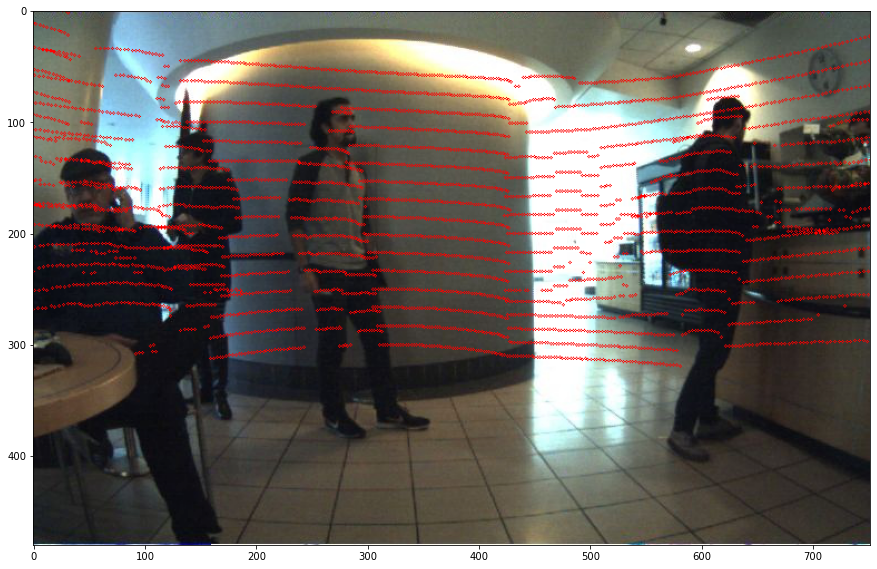

In [16]:
# Visualize
plt.figure(figsize=(15, 10))
image = cv2.imread(f"./sample_images/image_{sensor[-1]}/{loc}/000000.jpg")
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
for pts in pts_2d:
    cv2.circle(hsv_image, (np.int64(pts[0]), np.int64(pts[1])), 1, (0, 255, 255), 1)
hsv_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
plt.imshow(hsv_image)